In [87]:
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

# Part I: Preprocessing and EDA

## Problem 1

In [59]:
orders_raw = pd.read_csv('../src/data/Orders.csv')
returns_raw = pd.read_csv('../src/data/returns.csv')

In [61]:
returns = returns_raw.copy()
returns.columns = list(map(lambda s: re.sub('[. ]', '', s),  returns.columns))
orders = orders_raw.copy()
orders.columns = list(map(lambda s: re.sub('\.', '', s),  orders.columns))
#Cleaning Sales and Profit
orders['Sales'] = pd.to_numeric(pd.Series(map(lambda s: re.sub(r'[$,]', '', s),  orders['Sales'])))
orders['Profit'] = pd.to_numeric(pd.Series(map(lambda s: re.sub(r'[$,]', '', s),  orders['Profit'])))

## Problem 2

In [62]:
# Creating a Month column
orders['OrderDate'] = pd.to_datetime(orders['OrderDate'])
orders['OrderMonth'] = pd.DatetimeIndex(orders['OrderDate']).month

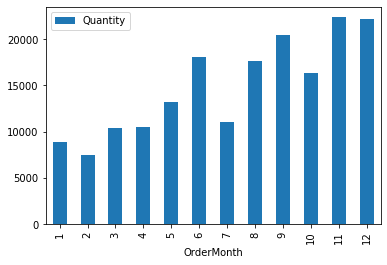

In [63]:
orders.groupby('OrderMonth')[['Quantity']].agg('sum').reset_index().plot.bar(x = 'OrderMonth', y = 'Quantity')

Orders seem to be concentrated after the month of June, especially June, September, November, December.

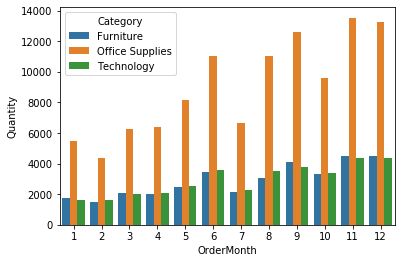

In [64]:
temp = orders.groupby(['OrderMonth', 'Category'])[['Quantity']].agg('sum').reset_index()
sns.barplot(data = temp, x = 'OrderMonth', y = 'Quantity', hue = 'Category')

The seasonal trend seems to be influenced mostly by office Supplies

## Problem 3

In [195]:
#Merging order with returns
orders_tot = orders.merge(returns[['Returned', 'OrderID']], on = 'OrderID', how = 'left')
#Changing nan to 'No': Not returned
orders_tot.loc[orders_tot['Returned'].isna(), 'Returned'] = 'No'

#### 1 How much profit did we lose due to returns each year?

In [120]:
# Proportion of retuned to not returned
orders_tot.groupby('Returned')['Returned'].agg('count')
# Total Profit loss by returns
orders_tot.groupby('Returned')['Profit'].agg('sum')['Yes'].round()

61371.0

#### 2 How many customer returned more than once? more than 5 times?

In [136]:
print("Number of customers that returned more than once: " \
      f"{np.sum(orders_tot.loc[orders_tot['Returned'] == 'Yes'].groupby('CustomerID')['CustomerID'].agg('count') > 1)}")
      
      
print("Number of customers that returned more than 5 times: " \
      f"{np.sum(orders_tot.loc[orders_tot['Returned'] == 'Yes'].groupby('CustomerID')['CustomerID'].agg('count') > 5)}")

Number of customers that returned more than once: 547
Number of customers that returned more than 5 times: 46


#### 3 Which regions are more likely to return orders?

In [165]:
orders_tot.loc[orders_tot['Returned'] == 'Yes'] \
          .groupby('Region')['Returned'].agg('count') \
          .sort_values(ascending = False)

Region
Central America      248
Western Europe       233
Western US           177
Oceania              154
Southeastern Asia    140
Eastern US           134
South America        133
Eastern Asia         131
Southern Europe      112
Southern Asia        111
Western Asia         108
Southern US           83
Northern Europe       76
Central US            74
Caribbean             69
Western Africa        60
North Africa          51
Eastern Europe        42
Southern Africa       25
Eastern Africa        18
Central Africa        17
Canada                15
Central Asia           9
Name: Returned, dtype: int64

Central America, Western Europe, Western US

#### 4 Which categories (sub-categories) of products are more likely to be returned?

In [189]:
total = orders_tot.groupby('SubCategory')['SubCategory'].agg('count')
returned = orders_tot.loc[orders_tot['Returned'] == 'Yes'] \
          .groupby('SubCategory')['Returned'].agg('count')
100*((returned/total).sort_values(ascending = False)).round(3)

SubCategory
Labels         5.3
Tables         4.8
Accessories    4.5
Art            4.5
Copiers        4.5
Binders        4.4
Phones         4.3
Bookcases      4.3
Paper          4.3
Chairs         4.3
Furnishings    4.3
Supplies       4.3
Machines       4.2
Storage        4.2
Envelopes      4.1
Fasteners      3.9
Appliances     3.4
dtype: float64

Labels with 5.3% return rate followed by Tables and Accessories with 4.8% and 4.5% return rates.

# Part II: Machine Learning and Business Use Case

## Problem 4: Feature Engineering

###### Step 1

In [201]:
# Dummify the Returned column
pd.get_dummies(orders_tot, columns = ['Returned'], drop_first=True)
# Another way
orders_tot.loc[orders_tot['Returned'] == 'Yes', 'Returned'] = 1
orders_tot.loc[orders_tot['Returned'] == 'No', 'Returned'] = 0
# 1 for returned
# 0 not returned

###### Step 2

In [205]:
# Parse ShipDate to datetime format
orders_tot['ShipDate'] = pd.to_datetime(orders_tot['ShipDate'])

In [207]:
orders_tot['ProcessTime'] = orders_tot['ShipDate'] - orders_tot['OrderDate']

###### Step 3

In [217]:
products_returned = orders_tot.groupby('ProductID')[['Returned']].agg('sum').reset_index()
products_returned.columns = ['ProductID', 'TimesReturned']
# Merge with the orders table
orders_tot = orders_tot.merge(products_returned, on = 'ProductID')

## Problem 5: Fitting Models

In [239]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [251]:
orders_feat = orders_tot.copy()

In [252]:
orders_feat = orders_feat[['ShipMode', 'Region', 'ProcessTime',
                           'ShippingCost', 'OrderPriority', 'Quantity', 
                           'Discount', 'Returned']]
orders_feat_d = pd.get_dummies(orders_feat, columns = ['ShipMode', 'Region', 'OrderPriority'], drop_first=True)

In [249]:
lr_model = LogisticRegression()
skf = StratifiedKFold(n_splits = 2)

In [ ]:
skf

In [254]:
orders_feat_d

,ProcessTime,ShippingCost,Quantity,Discount,Returned,ShipMode_Same Day,ShipMode_Second Class,ShipMode_Standard Class,Region_Caribbean,Region_Central Africa,...,Region_Southern Asia,Region_Southern Europe,Region_Southern US,Region_Western Africa,Region_Western Asia,Region_Western Europe,Region_Western US,OrderPriority_High,OrderPriority_Low,OrderPriority_Medium
0,2 days,40.770,2,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,4 days,32.980,7,0.4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2 days,923.630,9,0.1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2 days,328.659,4,0.2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5 days,222.780,6,0.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51285,7 days,5.170,3,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
51286,4 days,64.390,3,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
51287,3 days,63.010,8,0.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
51288,7 days,28.250,4,0.2,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
